### Import Libraries & Global Constants

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
#from sklearn.metrics import root_mean_squared_error

from sklearn.model_selection import train_test_split, KFold
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from scipy import stats

# Seed for reproducibility
SEED = 42

In [75]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, KFold
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge
from scipy import stats

### Load Data

In [50]:
# Load the data from the CSV file
#listings = pd.read_csv('../data/listings.csv')
listings = pd.read_csv('listings.csv.gz')

In [51]:
print(listings["neighbourhood_cleansed"].nunique())


17


# Exploratory Data Analysis

In [52]:
# Block for testing stuff

listings["room_type"].unique()

# Count the values of each of the room types
listings["room_type"].value_counts()


room_type
Entire home/apt    8747
Private room       1305
Shared room          46
Hotel room            1
Name: count, dtype: int64

## Data cleaning



In [53]:
def remove_columns(df, columns_to_remove):
    existing_columns = [col for col in columns_to_remove if col in df.columns]
    return df.drop(columns=existing_columns)

def clean_price(df):
    # First check that price is not already a numeric value
    if df['price'].dtype == np.float64:
        return df
    df_copy = df.copy()
    # Remove the commas and dollar signs from the price column
    df_copy['price'] = df_copy['price'].str.replace("$", "").str.replace(",", "").astype(float)
    return df_copy


def fill_missing_values(df):
    df_copy = df.copy()
    #If type is numeric, fill with mean
    for col in df_copy.select_dtypes(include='number').columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].mean())
    # Otherwise, if type is anything else, delete row
    df_copy = df_copy.dropna()

    return df_copy

def convert_boolean_columns(df):
    # Convert boolean columns to 0 and 1
    boolean_columns = df.select_dtypes(include='bool').columns
    df_copy = df.copy()
    for col in boolean_columns:
        df_copy[col] = df_copy[col].astype(int)

    # Needed since boolean data is inconsistent
    for col in df.columns:
        if set(df[col].unique()) == {'f', 't'}:
            df_copy[col] = df_copy[col].replace({'f': 0, 't': 1})
    return df_copy


def one_hot_encode_room_type(df):
    # One hot encode the room_type column
    # First check that the room_type column exists
    if 'room_type' not in df.columns:
        return df
    df_copy = pd.get_dummies(df, columns=['room_type'])
    return df_copy

def one_hot_encode_response(df):
    # One hot encode the room_type column
    # First check that the room_type column exists
    if 'host_response_time' not in df.columns:
        return df
    df_copy = pd.get_dummies(df, columns=['host_response_time'])
    return df_copy

In [64]:
columns_to_remove = [ 'id', 'listing_url', 'scrape_id', 'last_scraped', 
                     'source', 'name', 'description', 'neighborhood_overview', 
                     'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 
                     'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
                     'host_total_listings_count', 'host_verifications', 'neighbourhood', 
                     'neighbourhood_group_cleansed', 'property_type', 'bathrooms_text', 'amenities', 
                     'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                     'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                     'calendar_updated', 'calendar_last_scraped', 'number_of_reviews_l30d', 'first_review', 
                     'license',  'calculated_host_listings_count_entire_homes', 
                     'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'host_since','last_review' ]

def convert_categorical_columns(df):
    df_copy = df.copy()

    # Convert 'has_availability' from 't'/'f' to 1/0
    df_copy['has_availability'] = df_copy['has_availability'].replace({'t': 1, 'f': 0})

    # Label encode 'host_response_time'
    if 'host_response_time' in df_copy.columns:
        le = LabelEncoder()
        df_copy['host_response_time'] = le.fit_transform(df_copy['host_response_time'])

    # Drop 'neighbourhood_cleansed' and one-hot encode it
    if 'neighbourhood_cleansed' in df_copy.columns:
        df_copy = pd.get_dummies(df_copy, columns=['neighbourhood_cleansed'], drop_first=True)

    return df_copy

# Update the cleaning process
listings_clean = remove_columns(listings, columns_to_remove)
listings_clean = fill_missing_values(listings_clean)
listings_clean = clean_price(listings_clean)
listings_clean = one_hot_encode_room_type(listings_clean)
listings_clean = convert_boolean_columns(listings_clean)
listings_clean = convert_categorical_columns(listings_clean)

# After converting and cleaning, drop any remaining non-numeric columns
listings_cleant = listings_clean_one_hot.select_dtypes(exclude=['object'])


# Assert all values are numeric
assert listings_clean.dtypes.all() != np.dtype('O'), 'Not all values are numeric'


In [65]:
listings_clean.head(10)

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,...,neighbourhood_cleansed_Nordre Aker,neighbourhood_cleansed_Nordstrand,neighbourhood_cleansed_Sagene,neighbourhood_cleansed_Sentrum,neighbourhood_cleansed_St. Hanshaugen,neighbourhood_cleansed_Stovner,neighbourhood_cleansed_Søndre Nordstrand,neighbourhood_cleansed_Ullern,neighbourhood_cleansed_Vestre Aker,neighbourhood_cleansed_Østensjø
0,3,100%,100%,1,2,1,1,59.91201,10.72455,3,...,False,False,False,False,False,False,False,False,False,False
1,2,100%,67%,0,1,1,1,59.90795,10.77987,2,...,False,False,False,False,False,False,False,False,False,False
2,3,100%,96%,1,3,1,1,59.91074,10.77232,4,...,False,False,False,False,False,False,False,False,False,False
3,3,100%,96%,1,3,1,1,59.91253,10.77205,2,...,False,False,False,False,False,False,False,False,False,False
4,3,100%,67%,0,2,1,1,59.92398,10.74787,2,...,False,False,False,False,True,False,False,False,False,False
6,3,100%,100%,0,2,1,1,59.93024,10.75964,6,...,False,False,True,False,False,False,False,False,False,False
7,2,100%,78%,1,2,1,1,59.84704,10.77780,6,...,False,True,False,False,False,False,False,False,False,False
8,3,100%,67%,1,1,1,1,59.93061,10.75375,2,...,False,False,True,False,False,False,False,False,False,False
10,2,100%,94%,1,3,1,1,59.92085,10.74995,1,...,False,False,False,False,False,False,False,False,False,False
12,2,100%,71%,0,1,1,1,59.92634,10.75088,2,...,False,False,False,False,False,False,False,False,False,False


In [66]:
def convert_percentage_to_decimal(percentage_str):
    try: 
        float(percentage_str)
        return 0
    except:    
        p = percentage_str.strip('%')
    
        return int(p) / 100

In [67]:
listings_clean['host_response_rate'] = listings_clean['host_response_rate'].apply(convert_percentage_to_decimal)
listings_clean['host_acceptance_rate'] = listings_clean['host_acceptance_rate'].apply(convert_percentage_to_decimal)

In [68]:
listings_clean.dtypes

host_response_time                            int32
host_response_rate                          float64
host_acceptance_rate                        float64
host_is_superhost                             int64
host_listings_count                           int64
host_has_profile_pic                          int64
host_identity_verified                        int64
latitude                                    float64
longitude                                   float64
accommodates                                  int64
bathrooms                                   float64
bedrooms                                    float64
beds                                        float64
price                                       float64
minimum_nights                                int64
maximum_nights                                int64
has_availability                              int64
availability_30                               int64
availability_60                               int64
availability

In [69]:
print("Rows before cleaning",len(listings))
print("Number of columns before cleaning",len(listings.columns))
print("Rows after cleaning",len(listings_clean))
print("Number of columns after cleaning",len(listings_clean.columns))

Rows before cleaning 10099
Number of columns before cleaning 75
Rows after cleaning 6825
Number of columns after cleaning 52


C:\Users\20202894\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


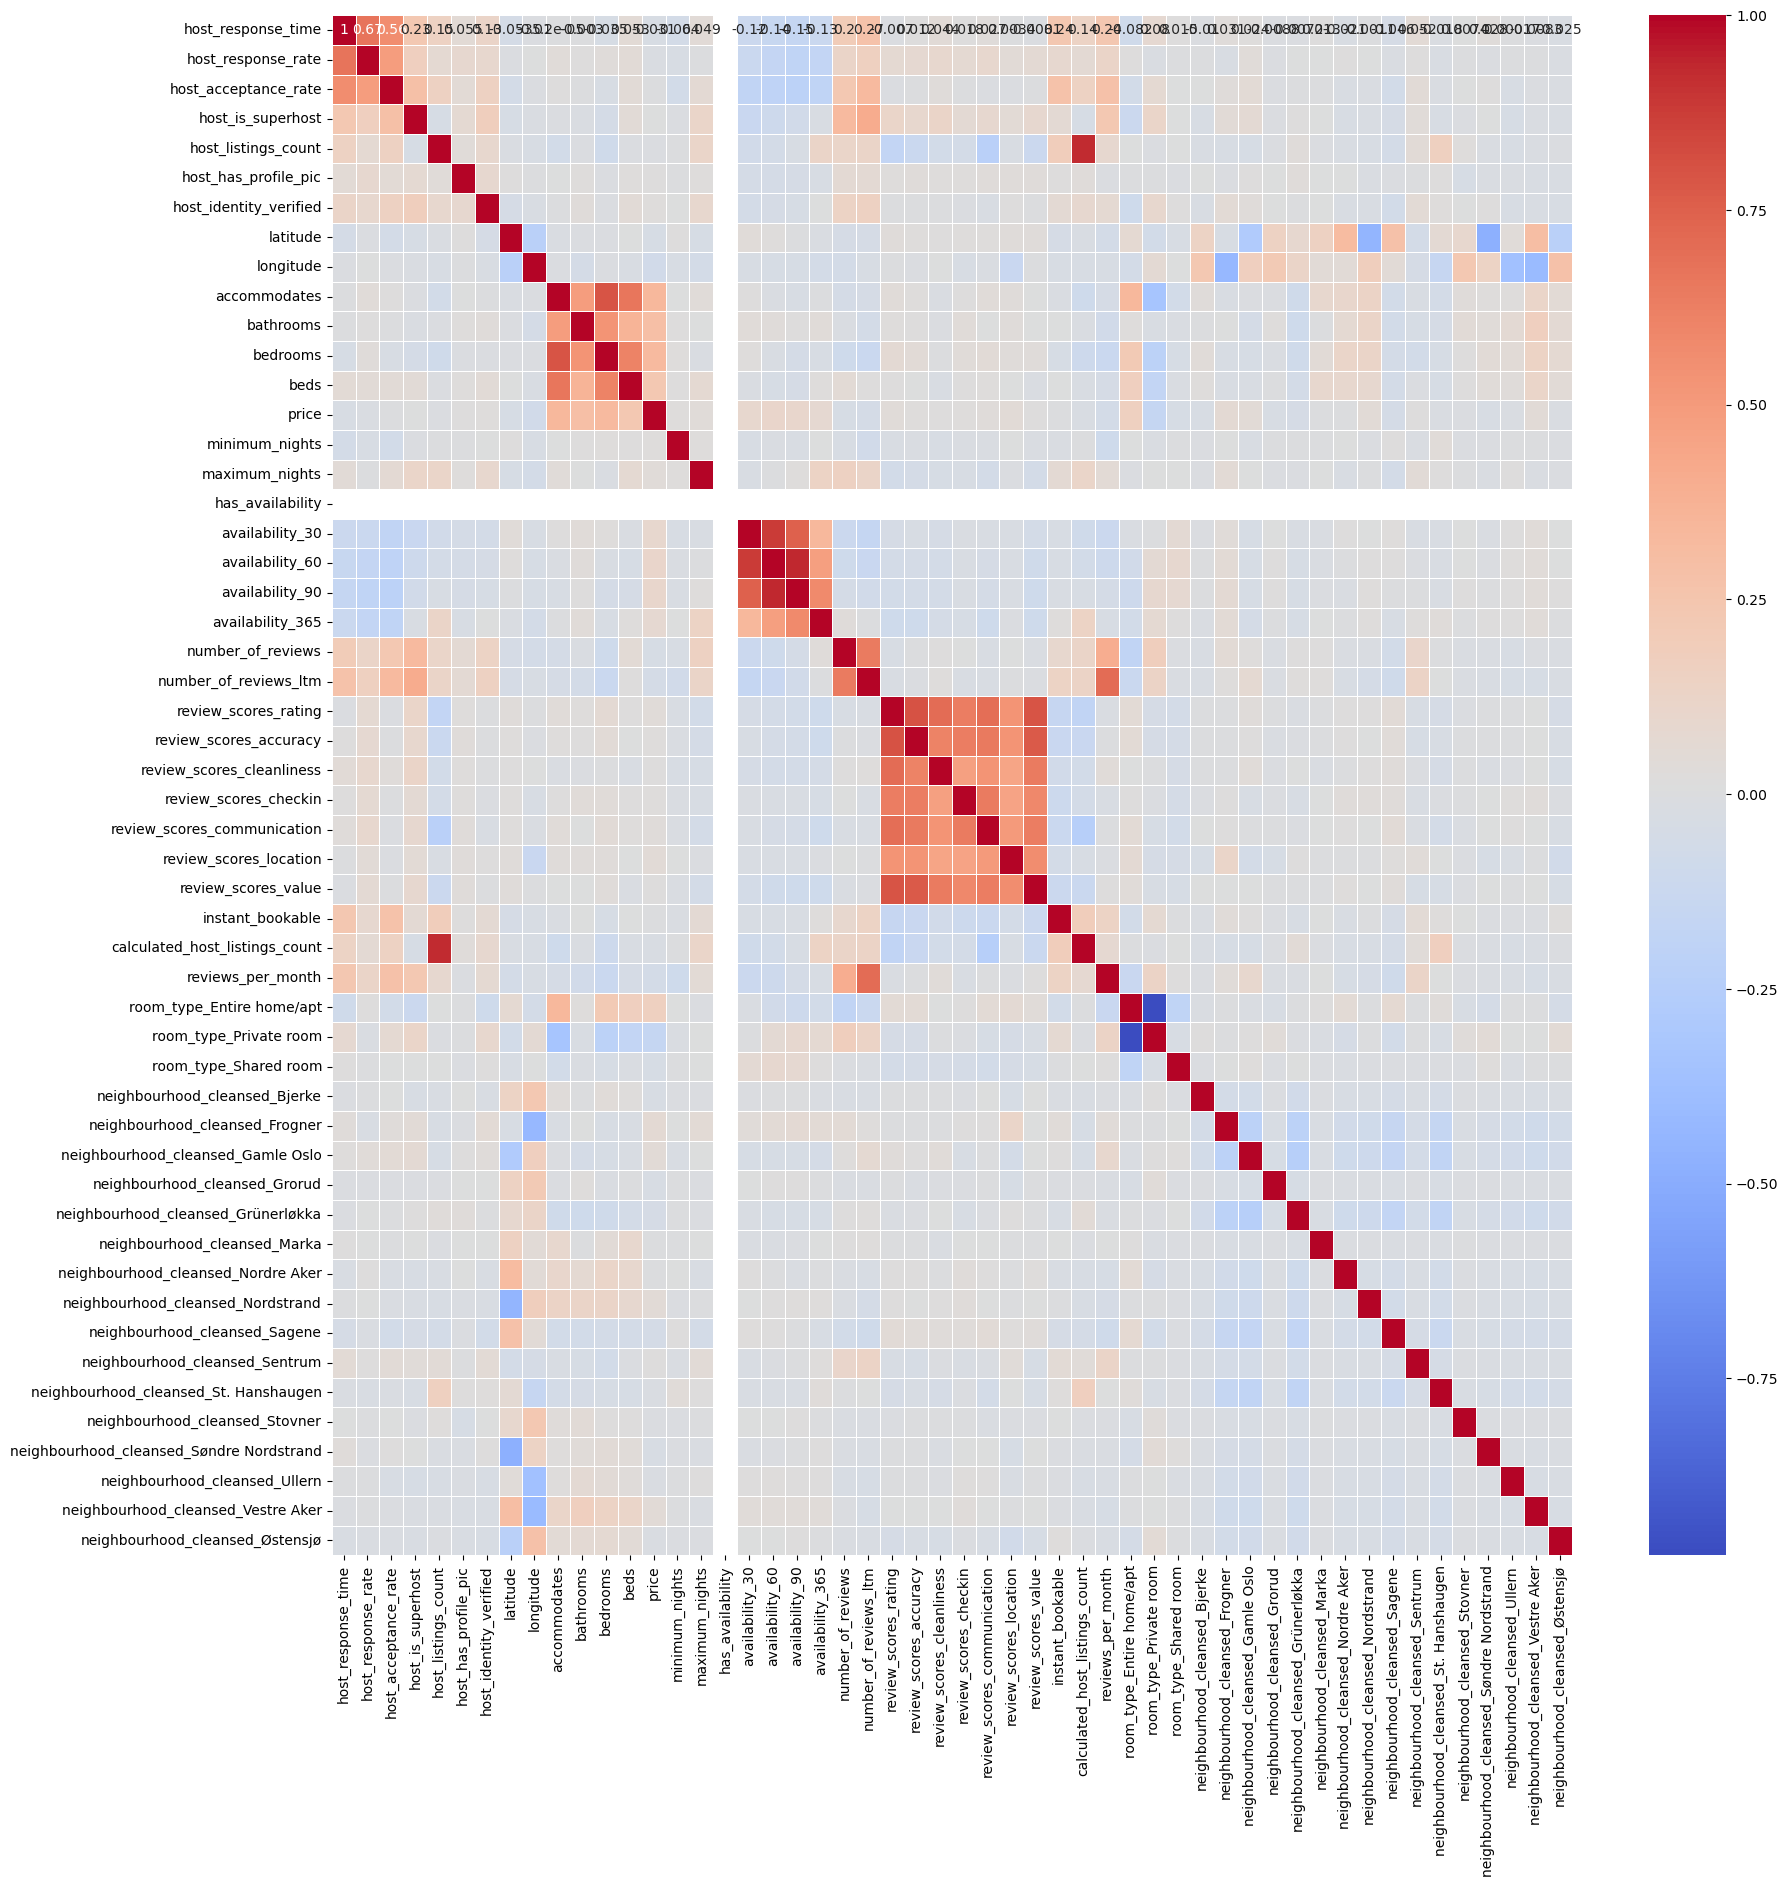

In [70]:
# Plot the correlation matrix
corr = listings_clean.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


This means removing 
- host_total_listings_count


# Quick modelling

In [ ]:
# Split the data into features and target
X = listings_clean.drop(columns='price')
y = listings_clean['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


In [ ]:
# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Print the coefficients and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2:", model.score(X_test, y_test))


# Feature Selection

In [76]:
def scale(df):
    scaler = MinMaxScaler()
    columns_to_scale = list(df.columns)
    columns_to_scale.remove('price')

    # Apply MinMaxScaler to the DataFrame
    df_scaled = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns=columns_to_scale)

    # Add the 'price' column back to the scaled DataFrame
    df_scaled['price'] = df['price'].values
    return df_scaled

In [82]:
def feature_selection(df):
    #scale the features first
    df = scale(df)
       
    X = df.drop('price', axis=1).copy()
    y = df['price'].copy()
    
    kf = KFold(n_splits=20, shuffle=True, random_state=SEED)

    rf_importances = np.zeros(X.shape[1])        
    ols_pvalues = np.zeros(X.shape[1])
    perm_importances = np.zeros(X.shape[1])
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
               
        rf_model = RandomForestRegressor(random_state=SEED)
        rf_model.fit(X_train, y_train)
        
        rf_importances += rf_model.feature_importances_
       
        ols_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
        ols_pvalues += ols_model.pvalues[1:]  #exclude the intercept p-value
        
        perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=50, random_state=SEED)
        perm_importances += perm_importance.importances_mean
    
    #average scores 
    rf_importances /= kf.get_n_splits()
    ols_pvalues /= kf.get_n_splits()
    ols_pvalues = ols_pvalues.round(5)
    perm_importances /= kf.get_n_splits()

    importance_df1 = pd.DataFrame({
        'Feature': X.columns,
        'RF Feature Importance': rf_importances,
    }).sort_values(by='RF Feature Importance', ascending=False)
  
    importance_df_ols = pd.DataFrame({
        'OLS P-Value': ols_pvalues,
    }).sort_values(by='OLS P-Value', ascending=True)
    
    perm_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Permutation Importance': perm_importances
    }).sort_values(by='Permutation Importance', ascending=False)

    return importance_df1, importance_df_ols, perm_importance_df

In [83]:
df_rf, df_ols, df_rf_perm = feature_selection(listings_clean.copy())

In [84]:
df_rf

,Feature,RF Feature Importance
10,bathrooms,0.133443
13,minimum_nights,0.113449
11,bedrooms,0.091430
7,latitude,0.083041
31,reviews_per_month,0.074925
1,host_response_rate,0.055582
9,accommodates,0.050759
8,longitude,0.037461
4,host_listings_count,0.032473
2,host_acceptance_rate,0.030014


set a cutoff e.g. 0.01 or 0.05

In [85]:
df_ols

,OLS P-Value
accommodates,0.00000
bathrooms,0.00000
bedrooms,0.00000
longitude,0.00237
neighbourhood_cleansed_Søndre Nordstrand,0.00629
availability_60,0.00647
host_acceptance_rate,0.00709
neighbourhood_cleansed_Ullern,0.01423
host_listings_count,0.02210
availability_30,0.02250


keep variables for which p-value < 0.05

In [86]:
df_rf_perm

,Feature,Permutation Importance
11,bedrooms,0.435386
10,bathrooms,0.169092
9,accommodates,0.086749
30,calculated_host_listings_count,0.076336
8,longitude,0.072119
20,number_of_reviews,0.067070
7,latitude,0.056044
4,host_listings_count,0.050897
32,room_type_Entire home/apt,0.048408
16,availability_30,0.047339


"The concept is really straightforward: We measure the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature. A feature is “important” if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is “unimportant” if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction" -- Analysis done on the test set